# Tutorial: AutoML Capabilities of H2O library - First Try

![h2o.ai](https://avatars0.githubusercontent.com/u/1402695?s=200&v=4)

자동화된 머신러닝(AutoML)은 머신러닝을 실제 문제에 적용하는 end-to-end 프로세스를 자동화하는 과정이다. 일반적인 머신러닝 애플리케이션에서 작업의 일반적인 단계(및 하위 단계)는 다음과 같다:

1. 데이터 준비
    * 데이터 전처리
    * 특성 공학
    * 특성 추출
    * 특성 선택
2. 모델 선택
3. 하이퍼파라미터 최적화 (최종 모델 성능을 극대화하기 위함)

이 단계들의 상당 수는 비전문가들의 능력 밖이다. **AutoML**은 갈수록 커지는 머신러닝 적용 과제에 인공지능 기반 솔루션으로 제안됐다.

AutoML의 다양한 단계를 다루는 주목할 만한 플랫폼 중 일부는 다음과 같다:
- [auto-sklearn](https://automl.github.io/auto-sklearn/stable/)은 [scikit-learn](https://scikit-learn.org/)베이시안 하이퍼파라미터 최적화 계층이다.
- [TPOT](https://github.com/EpistasisLab/tpot) (TeaPOT)는 파이썬 라이브러리로 유전 프로그래밍을 사용하여 완전한 머신러닝 파이프라인을 생성하고 최적화시킨다.
- [TransmogrifAI](https://github.com/salesforce/TransmogrifAI)은 Scala/SparkML 라이브러리로 [Salesforce](http://salesforce.com/)에 의해, 자동화된 데이터 클렌징, 특성 공학, 모델 선택, 하이퍼파라미터 최적화를 위해 만들어졌다.
- [H2O AutoML](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)은 (간단한) 데이터 전처리를 하고, 많은 후보 모델들을 학습하는 프로세스를 자동화하며, 모델의 하이퍼 파라미터 튜닝을 하고, stacking ensemble을 생성한다.
- [H2O Driverless AI](https://www.h2o.ai/products/h2o-driverless-ai/)는 상업적 소프트웨어 패키지로 머신러닝 애플리케이션의 많은 측면을 자동화한다. 그것은 자동 특성 공학에 초점을 맞추고 있다.

이 튜토리얼에서는 H2O 라이브러리인 AutoML 기능에 대한 개요를 소개한다. 라이브러리는 다음과 같이 간단히 설치할 수 있다.

In [1]:
!pip install h2o

필요한 패키지를 임포트하고 `h2o.init()`을 호출하자. `nthreads`와 `max_mem_size` 변수는 선택 사항이다.

In [2]:
import sys, os, os.path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle

import h2o
from h2o.automl import H2OAutoML

h2o.init(
    nthreads=-1,     # H2O 서버를 시작할 때 지정 쓰레드 수
    max_mem_size=12  # 단위는 기가바이트
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b01-1~deb9u1-b01); OpenJDK 64-Bit Server VM (build 25.212-b01, mixed mode)
  Starting server from /opt/conda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdrwlx9ko
  JVM stdout: /tmp/tmpdrwlx9ko/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdrwlx9ko/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,"1 year, 5 months and 26 days !!!"
H2O cluster name:,H2O_from_python_unknownUser_moisll
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Example 1: a classification task

H2O AutoMl을 [비행 지연시간 예측 대회의 데이터셋](https://www.kaggle.com/c/flight-delays-fall-2018)에 적용해보자. (이진 분류 작업)

In [3]:
train_df = pd.read_csv('../input/mlcourse/flight_delays_train.csv')
test_df = pd.read_csv('../input/mlcourse/flight_delays_test.csv')

In [4]:
print('train_df cols:', list(train_df.columns))
print('test_df cols: ', list(test_df.columns))
train_df.head()

train_df cols: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'dep_delayed_15min']
test_df cols:  ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance']


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
train_df.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

`Month`, `DayofMonth`, `DayofWeek`, `DepTime`, `Distance`는 숫자로 나타낼 수 있다. 이 피처들을 숫자형으로 변환해주다. (`HourFloat`라는 새로운 피처가 추가된다.)

In [6]:
for df in [train_df, test_df]:
    df['Month'] = df['Month'].apply(lambda s: s.split('-')[1]).astype('int')
    df['DayofMonth'] = df['DayofMonth'].apply(lambda s: s.split('-')[1]).astype('int')
    df['DayOfWeek'] = df['DayOfWeek'].apply(lambda s: s.split('-')[1]).astype('int')
    
    df['HourFloat'] = df['DepTime'].apply(
        lambda t: (t // 100) % 24 + ((t % 100) % 60) / 60
    ).astype('float')

`Origin`과 `Dest`를 합한 새로운 피처 `Route`를 생성하자.

In [7]:
for df in [train_df, test_df]:
    df['Route'] = df[['Origin', 'Dest']].apply(
        lambda pair: ''.join([str(a) for a in pair]),
        axis='columns'
    ).astype('str')

우리는 더이상 `DepTime` 컬럼을 사용하지 않을 것이다. `train_df`에서 타겟 컬럼을 피처 컬럼과 분리시켜주자.

In [8]:
target = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0})

feature_cols = [
    'Month', 'DayofMonth', 'DayOfWeek', 'HourFloat', 
    'UniqueCarrier', 'Origin', 'Dest', 'Route', 'Distance',]
train_df_modif = train_df[feature_cols]
test_df_modif = test_df[feature_cols]

`UniqueCarrier`, `Origin`, `Dest`, `Route`는 카테고리형이어야 한다.

In [9]:
N_train = train_df_modif.shape[0]
train_test_X = pd.concat([train_df_modif, test_df_modif], axis='index')

for feat in ['UniqueCarrier', 'Origin', 'Dest', 'Route']:
    train_test_X[feat] = train_test_X[feat].astype('category')

In [10]:
X_train = train_test_X[:N_train]
X_test = train_test_X[N_train:]
y_train = target

`H2OAutoML()`를 호출하기 전 판다스 데이터프레임은 H2O의 데이터프로임으로 변환해주어야 한다.

**NOTE :** 데이터를 전처리할 필요가 없다면, `df = h2o.import_file(datafile_apth)`와 같이 호출하여 데이터 파일에 직접 접근해 H2O 데이터프레임을 얻을 수 있다. (`datafile_path`는 파일 시스템 경로 혹은 URL이다.)

In [11]:
X_y_train_h = h2o.H2OFrame(pd.concat([X_train, y_train], axis='columns'))
X_y_train_h['dep_delayed_15min'] = X_y_train_h['dep_delayed_15min'].asfactor()
# 분류 작업시 타겟 값은 무조건 카테고리형이어야한다.
# 회귀 작업의 경우 타겟 값은 숫자형이어야 한다.

X_test_h = h2o.H2OFrame(X_test)

X_y_train_h.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:100000
Cols:10




,Month,DayofMonth,DayOfWeek,HourFloat,UniqueCarrier,Origin,Dest,Route,Distance,dep_delayed_15min
type,int,int,int,real,enum,enum,enum,enum,int,enum
mins,1.0,1.0,1.0,0.0,,,,,30.0,
mean,6.537639999999998,15.70384999999999,3.9518299999999824,13.605384666666659,,,,,729.3971600000004,
maxs,12.0,31.0,7.0,23.983333333333334,,,,,4962.0,
sigma,3.4134469010953556,8.793930776944096,1.9916398563478288,4.763861243104057,,,,,574.6168595588607,
zeros,0,0,0,12,,,,,0,
missing,0,0,0,0,0,0,0,0,0,0
0,8.0,21.0,7.0,19.566666666666663,AA,ATL,DFW,ATLDFW,732.0,0
1,4.0,20.0,3.0,15.8,US,PIT,MCO,PITMCO,834.0,0
2,9.0,2.0,5.0,14.366666666666667,XE,RDU,CLE,RDUCLE,416.0,0


In [12]:
aml = H2OAutoML(
    max_runtime_secs=(3600 * 8),  # 8 hours
    max_models=None,  # no limit
    seed=17
)

`H2OAutoML()`의 가장 중요한 매개변수(기본값 포함)는 다음과 같다:
- `nfolds=5` : K겹 교차 검증의 폴드 개수 (`nfolds=0`일 때는 교차 검증을 하지 않는다.)
- `balance_classes=False` : 오버샘플링/언더샘플링으로 학습 데이터의 클래스 수의 균형을 맞춘다.
- `max_runtime_secs=3600` : AutoML을 얼마동안 실행할건지 (초 단위)
- `max_models=None` : AutoML 실행시 빌드할 모델의 최대 개수 (`None`은 제한이 없음을 뜻한다.)
- `include_algos=None` : 모델 설계 단계에서 제한할 알고리즘 목록 (`exclude_algos` 매개변수와 함께 사용할 수 없다. `None`은 모든 적절한 H2O 알고리즘이 사용되는 것을 의미한다.)
- `exclude_algos=None` : 모델 설계 단계에서 스킵할 알고리즘 목록 (`None`은 모든 적절한 H2O 알고리즘이 사용되는 것을 의미한다.)
- `seed=None` : 재현성(reproducibility)를 위한 랜덤 시드값 (`max_models` 혹은 조기 학습 종료(early stopping)이 사용될 때만 AutoML은 재현성을 보장한다. 왜냐하면 실행 간 리소스가 동일하지 않을 경우, AutoML이 한 실행에서 다른 실행과 비교하여 더 많은 모델을 훈련할 수 있기 때문이다.)

H2O AutoML은 학습하고 교차검증을 한다:
- 기본 랜덤 포레스트 (DRF)
- 익스트림 랜덤 트리 (XRT)
- 일반화된 선형 모델의 랜덤 그리드 (GLM)
- XGBoost의 랜덤 그리드 (XGBoost)
- Gradient Boosting Machine의 랜덤 그리드 (GBM)
- 심층 신경망의 랜덤 그리드 (DeepLearning)
- 2개의 모델로 이루어진 스태킹 앙상블 (하나는 모든 모델 중 하나이고 다른 하나는 각 종류의 최고 성능 모델 중 하나)

아래 셀에서 `aml.train()`을 호출하고 리더보드와 각 모델들을 저장한다. 실행 시간은 대략 8시간으로, 한번 실행하고 출력 파일을 새로운 데이터셋으로써 저장하고 데이터셋을 이 커널에 연결하고 셀 안에 코드를 주석처리했다. 

In [13]:
%%time

# aml.train(
#     x=feature_cols,
#     y='dep_delayed_15min',
#     training_frame=X_y_train_h
# )

# lb = aml.leaderboard
# model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])
# out_path = "."

# for m_id in model_ids:
#     mdl = h2o.get_model(m_id)
#     h2o.save_model(model=mdl, path=out_path, force=True)

# h2o.export_file(lb, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


`H2OAutoML.train()`의 매개변수는 다음과 같다:
- `training_frame` : `x`와 `y`가 가리키는 컬럼을 가진 H2OFrame
- `x` : `training_frame`의 피처 컬럼 이름 목록
- `y` : 타켓 컬럼 이름
- `validation_frame` : 검증 데이터롤 사용할 H2OFrame (기본적으로 혹은 `nfolds` > 1이면 `validation_frame`이 무시된다.)
- `leaderboard_frame` : 리더보드 점수를 매기기 위한 테스트 데이터로 사용할 H2OFrame (선택사항; 기본적으로 `None`이고 이럴 경우 리더보드 순위를 매기기 위해 `training_frame`의 교차 검증 지표가 사용된다.)

리더보드를 살펴보자.

In [14]:
models_path = "../input/h2o-automl-saved-models-classif/"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))

#lb.head(rows=10)
lb.head(rows=lb.nrows)
# 전체 리더보드를 보기 위함

Parse progress: |█████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190414_112210,0.760626,0.414894,0.319628,0.360562,0.130005
StackedEnsemble_BestOfFamily_AutoML_20190414_112210,0.757001,0.417768,0.321114,0.361748,0.130862
XGBoost_grid_1_AutoML_20190414_112210_model_19,0.749523,0.417811,0.326181,0.362629,0.1315
XGBoost_grid_1_AutoML_20190414_112210_model_5,0.749192,0.419178,0.323792,0.363552,0.13217
XGBoost_2_AutoML_20190414_112210,0.748357,0.419561,0.325998,0.363667,0.132254
XGBoost_grid_1_AutoML_20190414_112210_model_14,0.748269,0.419371,0.326519,0.363586,0.132194
XGBoost_grid_1_AutoML_20190414_112210_model_7,0.747903,0.419317,0.328675,0.363493,0.132127
XGBoost_grid_1_AutoML_20190414_112210_model_11,0.747493,0.419303,0.328385,0.36345,0.132096
XGBoost_1_AutoML_20190414_112210,0.746212,0.420654,0.331262,0.364245,0.132674
XGBoost_grid_1_AutoML_20190414_112210_model_1,0.744129,0.422461,0.327766,0.365147,0.133332


단일 모델 중에 XGBoost는 (auc=0.749523)으로 이 작업에서 우수한 성능을 보여준다. 가장 좋은 단일 GBM은 `auc=0.741785`, 가장 좋은 XRT는 `auc=0.731317`, 가장 좋은 DRF는 `auc=0.725166`, 가장 좋은 DNN은 `auc=0.706676`을 가진다.

`StackedEnsemble_AllModels`은 보통 가장 좋은 성능을 보여주고, `StackedEnsemble_BestOfFamily`는 보통 2위를 했다. `StackedEnsemble_AllModels`의 내부를 살펴보자. AutoML 실행 시 모든 단일 모델의 앙상블이다.

In [15]:
se_all = h2o.load_model(os.path.join(models_path, "StackedEnsemble_AllModels_AutoML_20190414_112210"))
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se_all.metalearner()['name'])

AutoML 스태킹 앙상블은 기본 metalearner(combiner) 알고리즘으로 음이 아닌 가중치를 가진 GLM을 사용한다. 앙상블에서 metalearner 알고리즘의 가변적 중요도를 살펴보자. 이는 각 베이스 learner들이 앙승블에 얼마나 기여하고 있는지를 보여준다. 절편은 선형 모형에서 상수 항을 나타낸다.

(learner 혹은 metalearner는 앙상블에 사용된 모델들을 말하는 듯 하다.)

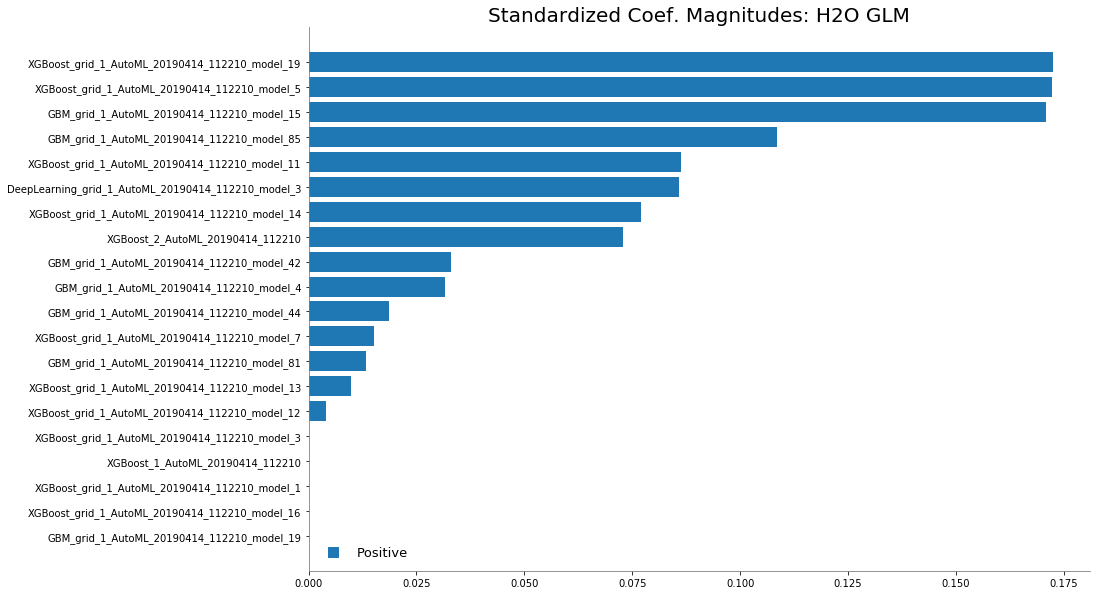

In [16]:
%matplotlib inline
metalearner.std_coef_plot(num_of_features=20)
# ^ all importance values starting from the 16th are zero

#metalearner.coef_norm()
# ^ to see the table in the text form

`StackedEnsemble_BestOfFamily`는 다음을 보여준다:

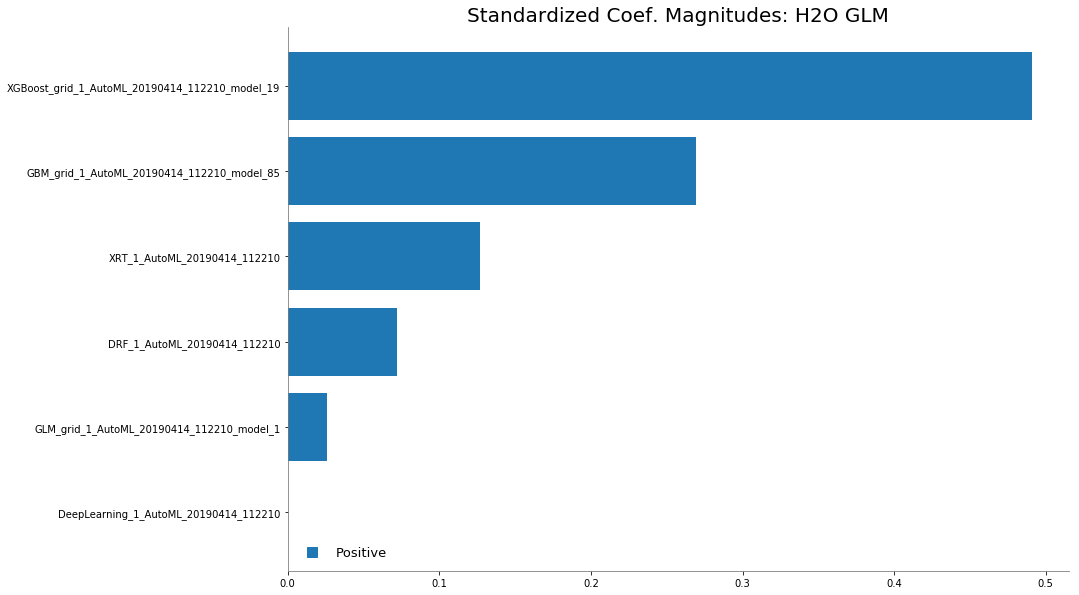

In [17]:
se_best_of_family = h2o.load_model(os.path.join(models_path, "StackedEnsemble_BestOfFamily_AutoML_20190414_112210"))
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se_best_of_family.metalearner()['name'])

%matplotlib inline
metalearner.std_coef_plot(num_of_features=10)
#metalearner.coef_norm()

몇몇 최고 성능 단일 모델의 결과(auc)를 재현해보자.

In [18]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

model_01 = h2o.load_model(os.path.join(models_path, "XGBoost_grid_1_AutoML_20190414_112210_model_19"))

excluded_params = ['model_id', 'response_column', 'ignored_columns']
model_01_actual_params = {k: v['actual'] for k, v in model_01.params.items() if k not in excluded_params}

reprod_model_01 = H2OXGBoostEstimator(**model_01_actual_params)
reprod_model_01.train(
    x=feature_cols,
    y='dep_delayed_15min',
    training_frame=X_y_train_h
)
reprod_model_01.auc(xval=True)
# ^ 0.749453, 리더보드와 비교했을 때 성능이 살짝 낮음

xgboost Model Build progress: |███████████████████████████████████████████| 100%


0.7494527766509888

In [19]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

model_12 = h2o.load_model(os.path.join(models_path, "GBM_grid_1_AutoML_20190414_112210_model_85"))

excluded_params = ['model_id', 'response_column', 'ignored_columns']
model_12_actual_params = {k: v['actual'] for k, v in model_12.params.items() if k not in excluded_params}

reprod_model_12 = H2OGradientBoostingEstimator(**model_12_actual_params)
reprod_model_12.train(
    x=feature_cols,
    y='dep_delayed_15min',
    training_frame=X_y_train_h
)
reprod_model_12.auc(xval=True)
# ^ 0.741785, 리더보드와 동일

gbm Model Build progress: |███████████████████████████████████████████████| 100%


0.7417847257072772

In [20]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

model_93 = h2o.load_model(os.path.join(models_path, "GLM_grid_1_AutoML_20190414_112210_model_1"))

excluded_params = ['model_id', 'response_column', 'ignored_columns', 'lambda']
model_93_actual_params = {k: v['actual'] for k, v in model_93.params.items() if k not in excluded_params}

reprod_model_93 = H2OGeneralizedLinearEstimator(**model_93_actual_params)
reprod_model_93.train(
    x=feature_cols,
    y='dep_delayed_15min',
    training_frame=X_y_train_h
)
reprod_model_93.auc(xval=True)
# ^ 0.699418,리더보드와 동일

glm Model Build progress: |███████████████████████████████████████████████| 100%


0.6994176421343811

기본 매개변수 값으로 `CatBoostClassifier`를 학습하고 AutoML로 돌렸을 때의 결과와 비교해보자.

In [ ]:
from catboost import Pool, CatBoostClassifier, cv

cb_model = CatBoostClassifier(
    eval_metric='AUC',
    use_best_model=True,
    random_seed=17
)

cv_data = cv(
    Pool(X_train, y_train, cat_features=[4,5,6,7]),
    cb_model.get_params(),
    fold_count=5,
    verbose=False
)

print("CatBoostClassifier: the best cv auc is", np.max(cv_data['test-AUC-mean']))

`CatBoostClassifier`의 교차검증 auc 결과는 0.749009이다. 이 값은 리더보드에서 2등(auc=0.749523)과 3등(auc=0.749192) 사이에 해당된다. 

## Example 2: a regression task

[뉴욕 택시 승차시간 예측 대회](https://www.kaggle.com/c/nyc-taxi-trip-duration)를 가지고 회귀 작업을 해보자. 이 대회는 뉴욕에서 총 승차시간을 예측하는 모델을 만드는 것이 목표이다. 데이터는 픽업시간, 좌표(위도/경도),고객의 수 그리고 다른 몇몇 피처로 구성되어 있다.

In [ ]:
df_train = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv', index_col=0)
df_test  = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv',  index_col=0)

우리는 `df_train`만 사용할 것이다. (이 데이터셋으로 5겹 교차검증을 수행한다) 날짜와 시간 관련 피처를 `datetime` 형태로 변환해준다; 탓 값인 `trip duration`에 로그를 취해준다. (`log(1 + x)`) 로그 변환 후, 타겟값의 분산은 정규분포에 가까워진다.

In [ ]:
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)
df_train['store_and_fwd_flag'] = 1 * (df_train.store_and_fwd_flag.values == 'Y')
df_train['check_trip_duration'] = (df_train['dropoff_datetime'] - df_train['pickup_datetime']).map(
    lambda x: x.total_seconds()
)
df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'].values)

cnd = np.abs(df_train['check_trip_duration'].values  - df_train['trip_duration'].values) > 1
duration_difference = df_train[cnd]

if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0:
    print('Trip_duration and datetimes are ok.')
else:
    print('Ooops.')

학습 데이터셋과 테스트 데이터셋의 공통 피처(컬럼)을 골라낸다; 그리고 `pd.DataFrame`을 `H2OFrame`으로 변환해준다.

In [ ]:
common_cols = [
    'vendor_id', 
    'pickup_datetime', 
    'passenger_count', 
    'pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag',
]

X_y_train_h = h2o.H2OFrame(
    pd.concat(
        [df_train[common_cols], df_train['log_trip_duration']],
        axis='columns'
    )
)

for ft in ['vendor_id', 'store_and_fwd_flag']:
    X_y_train_h[ft] = X_y_train_h[ft].asfactor()
    
X_y_train_h.describe()

아래 셀을 돌리고(~8시간), 모든 모델과 리더보드를 저장하고, 코드를 주석처리했다:

In [ ]:
# aml = H2OAutoML(
#     max_runtime_secs=(3600 * 8),  # 8 hours
#     max_models=None,  # no limit
#     seed=SEED,
# )

# aml.train(
#     x=common_cols,
#     y='log_trip_duration',
#     training_frame=X_y_train_h
# )

# lb = aml.leaderboard
# model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])
# out_path = "."

# for m_id in model_ids:
#     mdl = h2o.get_model(m_id)
#     h2o.save_model(model=mdl, path=out_path, force=True)

# h2o.export_file(lb, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)


흥미롭게도, 리더보드에는 오직 1개의 모델만이 있다.

In [ ]:
models_path = "../input/h2o-automl-saved-models-regress/"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb.head(rows=10)

모델의 결과인 `XGBoost_1_AutoML_20190417_212831`을 기본 값으로 된 `CatBoostRegressor`의 결과와 비교해보자.

In [ ]:
from catboost import Pool, CatBoostRegressor, cv

cb_model = CatBoostRegressor(
    eval_metric='RMSE',
    use_best_model=True,
    random_seed=17
)

cv_data = cv(
    Pool(df_train[common_cols], df_train['log_trip_duration'], cat_features=[0,7]),
    cb_model.get_params(),
    fold_count=5,
    verbose=False
)

In [ ]:
print("CatBoostRegressor: the best cv rmse is", np.min(cv_data['test-RMSE-mean']))

기본 값으로 학습된 `CatBoost`의 RMSE는 H2O AutoML로 돌린 XGBoost 모델의 RMSE보다 별로인 것을 볼 수 있다.

## Conclusion

내 생각에는 H2O AutoML을 시도해보는 것은 가치가 있다. 나는 네가 이 튜토리얼을 유용하게 썼으면 좋겠다.

아래 참고에 있는 "Scalable Automatic Machine Learning in H2O"에 엄청나게 유용한 "H2O AutoML 프로 팁"들이 담겨있다.

## References

* [H2O.ai](https://www.h2o.ai/)
* [H2O AutoML documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
* [AutoML Tutorial](https://github.com/h2oai/h2o-tutorials/tree/master/h2o-world-2017/automl): R and Python notebooks
* Intro to AutoML + Hands-on Lab: [1 hour video](https://www.youtube.com/watch?v=42Oo8TOl85I), [slides](https://www.slideshare.net/0xdata/intro-to-automl-handson-lab-erin-ledell-machine-learning-scientist-h2oai)
* Scalable Automatic Machine Learning in H2O: [1 hour video](https://www.youtube.com/watch?v=j6rqrEYQNdo), [slides](https://www.slideshare.net/0xdata/scalable-automatic-machine-learning-in-h2o-89130971)
* [H2O for GPU](https://www.h2o.ai/products/h2o4gpu/) (H2O4GPU)